# Data Mining HW3 
### 0310120 陳家煒

### Load package

<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

In [8]:
%matplotlib inline
import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np
from pandas.tseries.offsets import Minute
from sklearn.cluster import KMeans

style.use('ggplot')

### Load data

In [9]:
df_power = pd.read_csv('../input/Taipower.csv')

### Preprocessing ( data alignment, filling Nan value)

In [10]:
# get all PowerSupply data of (North)Taipei from Power.csv
NU = df_power.loc[df_power.Timestamp >= '2016-01-01 00:00:00', ['Timestamp','NorthUsage']]
NU = NU.loc[NU.Timestamp <= '2017-12-31 23:59:59', :]
NU['Datetime'] = pd.to_datetime(NU['Timestamp'])
# eliminate duplicate index value
NU = NU.drop_duplicates(subset='Timestamp', keep='last').set_index('Datetime')
NU = NU.drop(['Timestamp'],axis=1)
# data alignment
NU.index = NU.index - Minute(10)
# fillna with padding
NU = NU.resample('H').pad()
NU = NU.reset_index(drop = True)

In [11]:
NU.head()

,NorthUsage
0,841.3
1,826.4
2,789.5
3,773.6
4,778.0


## Task 1 prepare the dataset of NorthUsage 96 hour / 6 hour with sliding window slide 1 hour each time

In [12]:
X = list()
y = list()

In [13]:
NUM_DATA = len(NU) - 96 - 6
train_start = 0
train_end = 96
test_end = 102
for _ in range(NUM_DATA):
    X.append(NU.iloc[train_start:train_end,:].values.reshape(96))
    y.append(NU.iloc[train_end:test_end,:].values.reshape(6))
    train_start += 1
    train_end += 1
    test_end += 1

In [14]:
X = np.asarray(X)
y = np.asarray(y)

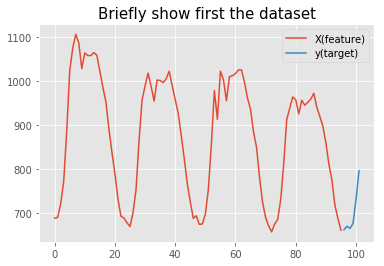

In [15]:
index_x = np.arange(96)
index_y = np.arange(6)+96

plt.title('Briefly show first the dataset',fontsize=15)
plt.plot(index_x,X[1000],label='X(feature)')
plt.plot(index_y,y[1000],label='y(target)')
plt.legend()
print

In [16]:
print X.shape
print y.shape

(8574, 96)
(8574, 6)


## Task 2 Randomly split the dataset into training and testing part (70%, 30%)

In [17]:
from sklearn.model_selection import train_test_split

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### Original first 3 dataset

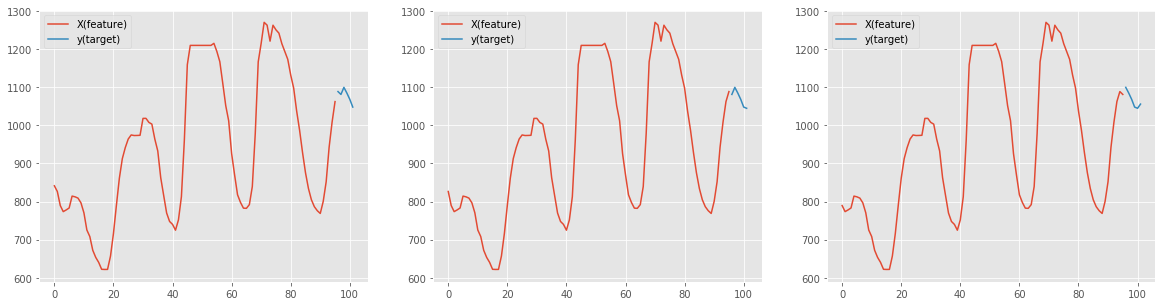

In [31]:
plt.figure(figsize=(20,5))
for i in range (3):
    plt.subplot(131+int(i))
    index_x = np.arange(len(X[i]))
    index_y = np.arange(len(y[i]))+len(X[i])
    #plt.figure()
    plt.plot(index_x,X[i],label='X(feature)')
    plt.plot(index_y,y[i],label='y(target)')
    plt.legend()

### After ramdom split first 3 training dataset

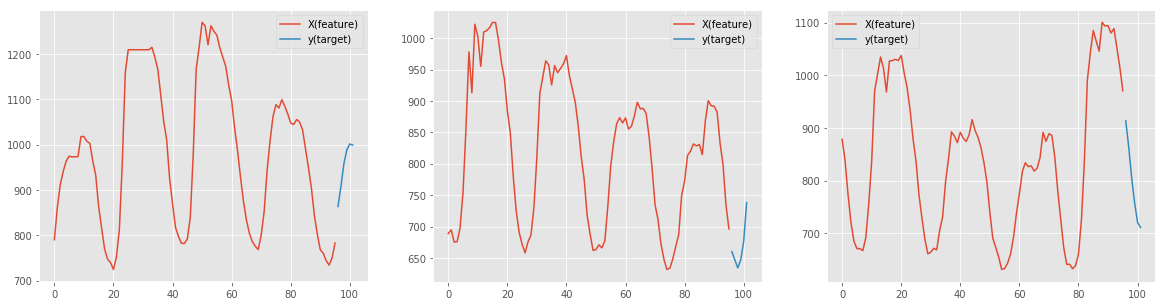

In [32]:
plt.figure(figsize=(20,5))
for i in range (3):
    plt.subplot(131+int(i))
    index_x = np.arange(len(X_train[i]))
    index_y = np.arange(len(y_train[i]))+len(X_train[i])
    #plt.figure()
    plt.plot(index_x,X_train[i],label='X(feature)')
    plt.plot(index_y,y_train[i],label='y(target)')
    plt.legend()

### After ramdom split first 3 testing dataset

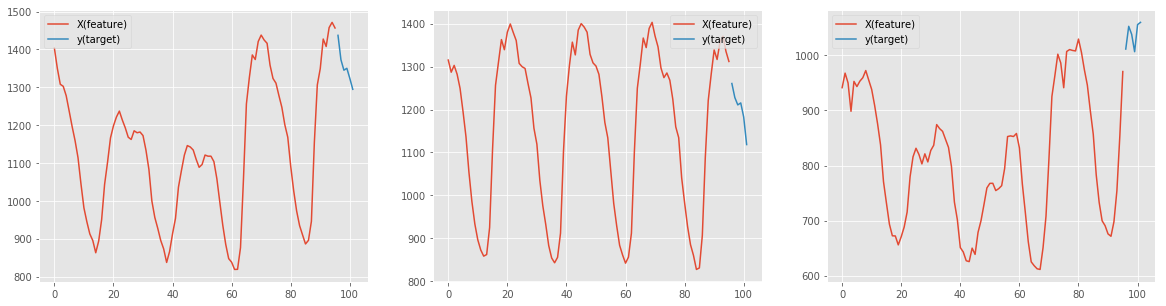

In [37]:
plt.figure(figsize=(20,5))
for i in range (3):
    plt.subplot(131+int(i))
    index_x = np.arange(len(X_test[i]))
    index_y = np.arange(len(y_test[i]))+len(X_test[i])
    plt.plot(index_x,X_test[i],label='X(feature)')
    plt.plot(index_y,y_test[i],label='y(target)')
    plt.legend()

## Task 3 training using specific models
classification : KNN, Naive Bayes, Random Forest, SVC, Others <br>
Regression: Bayesian regression, Decision tree regression, SVR, Others

### Regression
The coefficient R^2 is defined as (1 - u/v), where **u is the residual sum of squares ((y_true - y_pred)^2).sum()** and **v is the total sum of squares ((y_true - y_true.mean())^2).sum()**. The best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). A constant model that always predicts the expected value of y, disregarding the input features, would get a R^2 score of 0.0.

In [38]:
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import BayesianRidge

models_name = ['Bayesian regression','Decision tree regression','SVR']

models = [
    BayesianRidge(),
    DecisionTreeRegressor(),
    SVR(),
]

for idx, model in enumerate(models):
    start = time.time()
    model = MultiOutputRegressor(model, n_jobs=-1).fit(X_train, y_train)
    end = time.time()
    print "training",models_name[idx],"elapsed time:",end-start
    start = time.time()
    score = model.score(X_test, y_test)
    end = time.time()
    print "evaluation elapsed time:",end-start
    print models_name[idx],"with coefficient of determination R^2:",score
    print 
    
    #print models_name[idx],"with score:",model.score(X_test, y_test)


training Bayesian regression elapsed time: 0.889668941498
evaluation elapsed time: 0.186657905579
Bayesian regression with coefficient of determination R^2: 0.9509946886

training Decision tree regression elapsed time: 1.53613305092
evaluation elapsed time: 0.190612077713
Decision tree regression with coefficient of determination R^2: 0.927877882314

training SVR elapsed time: 10.3684182167
evaluation elapsed time: 4.07966208458
SVR with coefficient of determination R^2: 0.21741057186



### (bonus) Regression other model : AdaBoostRegressor

In [39]:
from sklearn.ensemble import AdaBoostRegressor 
start = time.time()
model = MultiOutputRegressor(AdaBoostRegressor(), n_jobs=-1).fit(X_train, y_train)
end = time.time()
print "training AdaBoostRegressor elapsed time:",end-start
start = time.time()
score = model.score(X_test, y_test)
end = time.time()
print "evaluation AdaBoostRegressor elapsed time:",end-start
print "AdaBoostRegressor with coefficient of determination R^2:",score
print 

training AdaBoostRegressor elapsed time: 15.2966768742
evaluation AdaBoostRegressor elapsed time: 0.308370113373
AdaBoostRegressor with coefficient of determination R^2: 0.837801640429



| Regression Model | R^2 | Training time(s) |  Prediction time(s) |
| -: |-------------: | :-: | :-: |
| Bayesian Regression| 0.950  | 0.889 | 0.186 |
| Decision Tree Regression| 0.927 | 1.536 | 0.190 |
| Support Vector Regression | 0.217 | 10.368 | 4.079 |
| (bonus) AdaBoostRegressor | 0.837 | 15.296 | 0.308 |


### Deal with classification problem

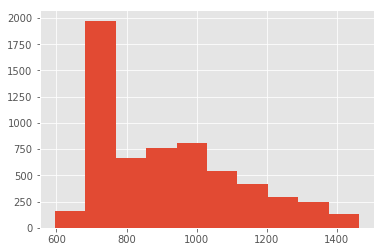

In [40]:
plt.hist(y_train.mean(axis=1))
print

### Apply pandas qcut to generate 5-class interval

In [18]:
qcut = pd.qcut(y_train.mean(axis=1), 5, retbins=True)
print qcut[1]

[  599.15         725.4          806.33333333   946.45        1100.16666667
  1463.88333333]


### Separate 6 - dim output to 6 different target for further training

In [43]:
y_train_cat_1 = pd.DataFrame(y_train[:,0])
y_test_cat_1 = pd.DataFrame(y_test[:,0])
y_train_cat_2 = pd.DataFrame(y_train[:,1])
y_test_cat_2 = pd.DataFrame(y_test[:,1])
y_train_cat_3 = pd.DataFrame(y_train[:,2])
y_test_cat_3 = pd.DataFrame(y_test[:,2])
y_train_cat_4 = pd.DataFrame(y_train[:,3])
y_test_cat_4 = pd.DataFrame(y_test[:,3])
y_train_cat_5 = pd.DataFrame(y_train[:,4])
y_test_cat_5 = pd.DataFrame(y_test[:,4])
y_train_cat_6 = pd.DataFrame(y_train[:,5])
y_test_cat_6 = pd.DataFrame(y_test[:,5])

### use pandas qcut to make a uniform distribution cutting label
continuous value -> categorical in interval **  [ 595 , 725.4 , 809 , 947.3 , 1098.85 ] **

In [44]:
def tran_to_cat(x):
    if x >= 595 and x < 725.4:
        return 0
    elif x >= 725.4 and x < 809:
        return 1
    elif x >= 809 and x < 947.3:
        return 2
    elif x >= 947.3 and x < 1098.85:
        return 3
    else:
        return 4

y_train_cat_1 = y_train_cat_1[0].apply(tran_to_cat)
y_test_cat_1 = y_test_cat_1[0].apply(tran_to_cat)
y_train_cat_2 = y_train_cat_2[0].apply(tran_to_cat)
y_test_cat_2 = y_test_cat_2[0].apply(tran_to_cat)
y_train_cat_3 = y_train_cat_3[0].apply(tran_to_cat)
y_test_cat_3 = y_test_cat_3[0].apply(tran_to_cat)
y_train_cat_4 = y_train_cat_4[0].apply(tran_to_cat)
y_test_cat_4 = y_test_cat_4[0].apply(tran_to_cat)
y_train_cat_5 = y_train_cat_5[0].apply(tran_to_cat)
y_test_cat_5 = y_test_cat_5[0].apply(tran_to_cat)
y_train_cat_6 = y_train_cat_6[0].apply(tran_to_cat)
y_test_cat_6 = y_test_cat_6[0].apply(tran_to_cat)

In [45]:
Y_train_cat = [y_train_cat_1,y_train_cat_2,y_train_cat_3,y_train_cat_4,y_train_cat_5,y_train_cat_6]
Y_test_cat = [y_test_cat_1,y_test_cat_2,y_test_cat_3,y_test_cat_4,y_test_cat_5,y_test_cat_6]

In [33]:
acc = [0.0,0.0,0.0,0.0]

In [34]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

models_name = ['KNeighborsClassifier',
               'GaussianNB',
               'RandomForestClassifier',
               'SVC']

models = [
    KNeighborsClassifier(),
    GaussianNB(),
    RandomForestClassifier(),
    SVC()
]
for i in range(6):
    for idx, model in enumerate(models):
        print "predict future",i+1,"hour"
        start = time.time()
        model.fit(X_train, Y_train_cat[i])
        end = time.time()
        print "training",models_name[idx],"elapsed time:",end-start
        start = time.time()
        score = model.score(X_test, Y_test_cat[i])
        acc[idx] += score/6.0
        end = time.time()
        print "evaluation elapsed time:",end-start
        print models_name[idx],"with accuracy:",round(score*100,3),"%"
        print 

predict future 1 hour
training KNeighborsClassifier elapsed time: 0.0272369384766
evaluation elapsed time: 0.716556072235
KNeighborsClassifier with accuracy: 85.659 %

predict future 1 hour
training GaussianNB elapsed time: 0.0101139545441
evaluation elapsed time: 0.0141038894653
GaussianNB with accuracy: 73.766 %

predict future 1 hour
training RandomForestClassifier elapsed time: 0.343324899673
evaluation elapsed time: 0.0106568336487
RandomForestClassifier with accuracy: 90.478 %

predict future 1 hour
training SVC elapsed time: 6.89530706406
evaluation elapsed time: 1.38266706467
SVC with accuracy: 43.646 %

predict future 2 hour
training KNeighborsClassifier elapsed time: 0.0201640129089
evaluation elapsed time: 0.697299003601
KNeighborsClassifier with accuracy: 85.426 %

predict future 2 hour
training GaussianNB elapsed time: 0.00947904586792
evaluation elapsed time: 0.0128691196442
GaussianNB with accuracy: 70.152 %

predict future 2 hour
training RandomForestClassifier elapsed 

In [37]:
print np.asarray(acc)*100

[ 84.80373105  70.15805156  87.56963337  43.80101049]


### (bonus) Classification other model : lightgbm

In [41]:
from lightgbm import LGBMClassifier

model = LGBMClassifier(task='train',boosting_type='dart', objective='multiclass',
                       num_iteration=1000,num_leaves=100,
                       is_enable_sparse='True',tree_learner='data',min_data_in_leaf=20,max_depth=5,
                       learning_rate=0.05,max_bin=128, 
                       subsample_freq=2, colsample_bytree=0.5, reg_alpha=1, 
                       reg_lambda=0, seed=0, nthread=-1, silent=False)

In [47]:
##Fit to training data
#start = time.time()
#model.fit(X_train, y_train_cat)
#end = time.time()
#
##Generate Predictions
#start = time.time()
#y_pred=model.predict(X_test)
#end = time.time()
#print "evaluation elapsed time:",end-start

y_pred = list()

for i in range(6):
    print "predict future",i+1,"hour"
    start = time.time()
    model.fit(X_train, Y_train_cat[i])
    end = time.time()
    print "training lightgbm elapsed time:",end-start
    start = time.time()
    y_pred.append(model.predict(X_test))
    #score = model.score(X_test, Y_test_cat[i])
    #acc[idx] += score/6.0
    end = time.time()
    print "evaluation elapsed time:",end-start
    #print "lightgbm with accuracy:",round(score*100,3),"%"
    print 

predict future 1 hour
training lightgbm elapsed time: 63.8290929794
evaluation elapsed time: 0.500102043152

predict future 2 hour
training lightgbm elapsed time: 60.7064950466
evaluation elapsed time: 0.539016008377

predict future 3 hour
training lightgbm elapsed time: 63.8571200371
evaluation elapsed time: 0.556576967239

predict future 4 hour
training lightgbm elapsed time: 63.9821910858
evaluation elapsed time: 0.618397951126

predict future 5 hour
training lightgbm elapsed time: 64.4568750858
evaluation elapsed time: 0.580841064453

predict future 6 hour
training lightgbm elapsed time: 64.3332030773
evaluation elapsed time: 0.569066047668



In [51]:
acc = 0.0
from sklearn.metrics import accuracy_score
for i in range(6):
    score = accuracy_score(Y_test_cat[i], y_pred[i])
    #print round(score*100,3),"%"
    acc += score/6
#score = accuracy_score(y_test_cat, y_pred)
print round(acc*100,3),"%"


90.245 %


|Classification Model | Accuracy | Training time(s) |  Prediction time(s) |
| -: |-------------: | :-: | :-: |
| KNeighborsClassifier | 84.803 %  | 0.01 | 0.346 |
| GaussianNB| 70.158 % | 0.003 | 0.002 |
| RandomForestClassifier | 87.569 % | 0.186 | 0.003 |
| Support Vector Classifier | 43.801 % | 4.471 | 1.084 |
| (bonus) Lightgbm | 90.245 % |  64.514 | 0.569 |

## (bonus) Task 4 Model tuning

#### Default Random Forest: 
RandomForestClassifier(n_estimators=10, criterion=’gini’, max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features=’auto’, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=1, random_state=None, verbose=0, warm_start=False, class_weight=None)

In [35]:
from sklearn.model_selection import GridSearchCV


# Set the parameters by cross-validation
tuned_parameters = [{'min_samples_leaf':[1,5,10,50,100,200,500],
                     'criterion':['gini','entropy'],
                     'max_depth':[5,10,20,30,None],
                     }]
start = time.time()
clf = GridSearchCV(RandomForestClassifier(), tuned_parameters, cv=5)
clf.fit(X_train, y_train_cat)
print clf.best_params_
end = time.time()
print "elapsed time:",end-start

{'criterion': 'entropy', 'max_depth': 30, 'min_samples_leaf': 1}
elapsed time: 56.3615589142


**Random Forest with default parameters**

In [42]:
original_clf = RandomForestClassifier()
start = time.time()
original_clf.fit(X_train, y_train_cat)
end = time.time()
print "training elapsed time:",end-start
start = time.time()
score = original_clf.score(X_test, y_test_cat)
end = time.time()
print "evaluation elapsed time:",end-start
print 'Default RandomForestClassifier accuracy:',round(score*100,3),"%"

training elapsed time: 0.192899227142
evaluation elapsed time: 0.00319504737854
Default RandomForestClassifier accuracy: 87.291 %


 **Random Forest with best parameters {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1}**

In [43]:
tuning_clf = RandomForestClassifier(min_samples_leaf=1,max_depth=30,
                                    criterion='entropy',max_features=None)
start = time.time()
tuning_clf.fit(X_train, y_train_cat)
end = time.time()
print "training elapsed time:",end-start
start = time.time()
score = tuning_clf.score(X_test, y_test_cat)
end = time.time()
print "evaluation elapsed time:",end-start
print 'Tuning RandomForestClassifier accuracy:',round(score*100,3),"%"

training elapsed time: 4.05344796181
evaluation elapsed time: 0.00287103652954
Tuning RandomForestClassifier accuracy: 89.234 %


| Random Forest | Accuracy | Training time(s) |  Prediction time(s) |
| -: |-------------: | :-: | :-: |
| default | 87.291 %  | 0.192 | 0.003 |
| after tuning | 89.234 % | 4.053 | 0.003 |